In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from datetime import datetime, timedelta
import time

# 1. Measuring Retail Investor Sentiment from WallStreetBets

In [3]:
# load data from csv
df_reddit = pd.read_csv(r'reddit_wsb.csv', index_col=7)
df_returns = pd.read_csv(r'crsp_daily.csv', low_memory=False)

df_reddit.index = pd.to_datetime(df_reddit.index)

In [4]:
# combine title and body, clean up, and split sentences into individual words
df_reddit['body'] = df_reddit['body'].fillna('')
df_reddit['post'] = df_reddit['title'] + ' ' + df_reddit['body']
df_reddit['post'] = df_reddit['post'].apply(lambda x: x.strip())

for i in ')(,.!-:;><{}[]':
    df_reddit['post'] = df_reddit['post'].str.replace(i, "", regex=True)

df_reddit['post_split'] = df_reddit['post'].str.split(' ')

# count the number of words in each post
df_reddit['word_count'] = df_reddit['post_split'].str.len()

## 1.1 (a) Report summary statistics for the number of words of the title+body column

In [5]:
mean = np.mean(df_reddit['word_count'].values)
median = np.median(df_reddit['word_count'].values)
maximum = max(df_reddit['word_count'].values)
minimum = min(df_reddit['word_count'].values)
stdev = np.nanstd(df_reddit['word_count'].values)

summary_stats_dict = {'mean':mean,'median':median,'max':maximum,'min':minimum,'standard dev': stdev}

summary_stats = pd.DataFrame.from_dict(summary_stats_dict,orient='index',columns=['summary statistics'])
summary_stats = round(summary_stats,2)
summary_stats

,summary statistics
mean,109.97
median,18.00
max,7873.00
min,1.00
standard dev,286.27


## 1.1 (b) Plot the number of posts by month

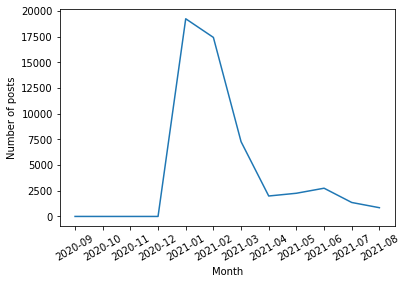

In [6]:
# group by month and count number of posts by month
per_month = df_reddit.word_count.groupby(pd.Grouper(freq="M")).count()
per_month.index = per_month.index.strftime('%Y-%m')

# plot 
plt.plot(per_month)
plt.xticks(rotation=30, fontsize=10)
plt.xlabel("Month")
plt.ylabel("Number of posts")
plt.show()

## 1.2 Record which tickers are mentioned in each post and report the number of posts that contain a ticker

In [7]:
# get list of tickers
remove_words = ['YOLO', 'BUY', 'DD', 'GO', 'GAIN']

for i in range(len(remove_words)):
    df_returns = df_returns[df_returns.TICKER != remove_words[i]]

tickers = df_returns.TICKER.unique()
tickers = [x for x in tickers if str(x) != 'nan']
tickers = ['$' + i for i in tickers]

In [8]:
# check for tickers without $
tickers2 = []

for t in tickers:
    
    if t[0] == '$':
        tickers2.append(t[1:])

In [9]:
tickers = tickers + tickers2

In [10]:
# find posts that mention tickers

# Note: we are only searching for tickers preceded by a dollar sign. We do this because it is not feasable 
# in this contxt to differentiate between tickers such as $FOR and $F and uses of FOR and F in regular language.
# As with any forum scraping, the dataset is subject to error, which we attempt to minimize

df_reddit['tickers'] = df_reddit['post_split'].apply(lambda x: list(set(x).intersection(tickers)))

df1 = df_reddit[['post','tickers']].head(15).tail(5)
pd.set_option('expand_frame_repr', False)
with pd.option_context('expand_frame_repr', False):
    print (df1)

                                                                  post                         tickers
timestamp                                                                                             
2021-01-28 21:18:25  We need to keep this movement going we all can...                      [GME, AMC]
2021-01-28 21:17:28                 GME Premarket 🍁 Musk approved 🎮🛑💎✋                           [GME]
2021-01-28 21:17:10  Once you're done with GME  $AG and $SLV the ge...  [GME, BE, OUT, $AG, $SLV, JPM]
2021-01-28 21:15:58  $GME price has nothing to do with fundamentals...            [ITM, $GME, EOD, OI]
2021-01-28 21:14:44                                 I Love You Retards                              []


In [11]:
# count number of posts mentioning tickers

print(str(len(df_reddit[df_reddit["tickers"].astype(bool)]))+' posts with ticker mentions')

30728 posts with ticker mentions


In [12]:
# df_reddit.to_csv(r'/Users/christianpavilanis/Downloads/problem_set4-1.csv')
df = pd.DataFrame(tickers)
# df.to_csv(r'/Users/christianpavilanis/Downloads/tickers.csv')

## 1.3 Regress returns on an indicator for whether the ticker was mentioned in any WSB posts on a given day or on the prior day

## 1.5 For each post, count the instances of the phrases "buy", "sell", "hold", "short". Construct the measure "RedditRec" and regress against next day returns

In [13]:
def reddit_rec(post):
    
    num = 0
    denom = 0
        
    if ('buy' in post) or ('Buy' in post) or ('BUY' in post):
        num += 1
        denom += 1
    if ('hold' in post) or ('Hold' in post) or ('HOLD' in post):
        num += 1
        denom += 1
    if ('sell' in post) or ('Sell' in post) or ('SELL' in post):
        num -= 1
        denom += 1
    if ('short' in post) or ('Short' in post) or ('SHORT' in post):
        num -= 1
        denom += 1
        
    if denom > 0:
        return num / denom 
    else:
        return 0

In [14]:
df_reddit["RedditRec"] = df_reddit["post"].apply(lambda x: reddit_rec(x))

In [15]:
df_returns['time'] = df_returns['date'].apply(lambda x: time.mktime(datetime.strptime(str(x), "%Y%m%d").timetuple()))

In [16]:
df_returns['datetime'] = df_returns['time'].apply(lambda x: datetime.fromtimestamp(x))

In [17]:
df_reddit = df_reddit.reset_index()

In [18]:
df_rec = pd.DataFrame(df_reddit[df_reddit["RedditRec"] != 0])

In [19]:
def is_ticker(x):
    if len(x) > 0:
        return 1
    else:
        return 0

In [20]:
df_rec['is_ticker'] = df_rec['tickers'].apply(lambda x: is_ticker(x))

In [21]:
df_rec = pd.DataFrame(df_rec[df_rec['is_ticker'] > 0])

In [22]:
def clean_ticker(t_list):
    
    cleaned_list = []
    
    for t in t_list:
        cleaned_list.append(t.replace('$', ''))
        
    return [*set(cleaned_list)]

In [23]:
df_rec['unique_tickers'] = df_rec['tickers'].apply(lambda x: clean_ticker(x))

In [24]:
def get_rets(ticker, df_rets, post_time):
    
    df = df_rets[df_rets["TICKER"] == ticker]
    
    df = df[df['datetime'] > post_time]
        
    if len(df) == 0:
        return np.nan
    
    try:
        ret = float(df[df['datetime'] > post_time].iloc[0].RET)
    except ValueError:
        ret = np.nan
        
    return ret

In [25]:
def next_day_rets(row, df_rets):
    
    tickers = row.unique_tickers # list of tickers
    
    nd_ret = 0
    post_time = row.timestamp
        
    for t in tickers:
        nd_ret += get_rets(t, df_rets, post_time)
        
    return nd_ret / len(tickers)

In [26]:
# df_rec = pd.DataFrame(df_rec.iloc[0:300])

# this takes a long time to run. Trim it down by uncommenting the above
df_rec['next_day_rets'] = df_rec.apply(lambda row: next_day_rets(row, df_returns), axis=1)

In [27]:
df_rec_cleaned = pd.DataFrame(df_rec.dropna())

In [28]:
X = np.asarray(df_rec_cleaned['RedditRec'])
X = sm.add_constant(X)
y = np.asarray(df_rec_cleaned['next_day_rets'])

In [29]:
est = sm.OLS(y, X).fit()

In [30]:
betas = est.params

In [31]:
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.5362
Date:                Tue, 15 Nov 2022   Prob (F-statistic):              0.465
Time:                        21:19:01   Log-Likelihood:                -30.313
No. Observations:                 259   AIC:                             64.63
Df Residuals:                     257   BIC:                             71.74
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2948      0.019     15.433      0.000       0.257       0.332
x1             0.0151      0.021      0.732      0.465      -0.025       0.056
==============================================================================
Omnibus:                     4630.550   Durbin-Watson:                   1.830
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               23.720
Skew:                           0.166   Prob(JB):                     7.07e-06
Kurtosis:                       1.555   Cond. No.                         1.65
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

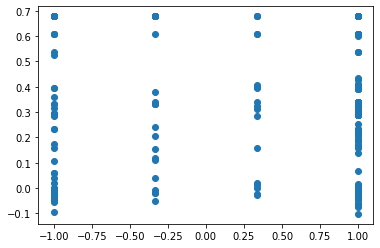

In [32]:
plt.scatter(np.asarray(df_rec_cleaned['RedditRec']), np.asarray(df_rec_cleaned['next_day_rets']))

## 1.6 Comment on results from 3-5

The result in part 5 gives a very low r2 value which can be easily observed in the above scatter plot. The measure of sentiment in this section is quote simple and only yields four different values. This makes it difficult to run a reliable linear regression. A more comprehensive measure of sentiment, such as a measure that resulted in a wider range of values, could give a more linear relationship.

## 1.7 Describe the shortcomings of this simple measure of sentiment

The simple nature of this method of calculating 'RedditRec' is intuitive but not rigorous. To get a more powerful result, we would need to refine the way we calculate our sentiment score. Specifically, checking for just the presense of these four words is not enough. There are many other words or phrases that could be tested for to measure the sentiment. Also, many of these posts are in jest, so a post with sell may acutally be a positive or neutral sentiment.
A better methodology would be to train a machine learning algorithm on words and phrases that appear in this post. And rather than a +1 or -1 it could yield a more comprehensive score such as a number out of 100. A more complex method of measuring sentiment would yield much stronger results.